In [ ]:
!pip install Bio
!pip install import-ipynb
# !pip install wandb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
# import wandb
from datetime import datetime

# so we can import utils notebook (delete if working on Pycharm), you might need to change it to your working directory path
%cd "/content/drive/MyDrive/ColabNotebooks_short"
import import_ipynb
import utils

In [11]:
###############################################################################
#                                                                             #
#              Parameters you can change, but don't have to                   #
#                                                                             #
###############################################################################


# number of ResNet blocks for the first ResNet and the kernel size.
RESNET_1_BLOCKS = 1
RESNET_1_KERNEL_SIZE = 9
RESNET_1_KERNEL_NUM = 16

###############################################################################
#                                                                             #
#                        Parameters you need to choose                        #
#                                                                             #
###############################################################################


# number of ResNet blocks for the second ResNet, dilation list to repeat and the kernel size.

RESNET_2_BLOCKS = 5
RESNET_2_KERNEL_SIZE = 5  # good start may be 3/5
RESNET_2_KERNEL_NUM = 28 # DO NOT MAKE IT 1!
DILATION = [1]
WANTED_M = len(DILATION) # len of DILATION to be randomize by 'wandb' tool

# percentage of dropout for the dropout layer
DROPOUT = 0.289580549283963   # good start may be 0.1-0.5

# number of epochs, Learning rate and Batch size
EPOCHS = 9
LR = 0.0019210418506367384 # good start may be 0.0001/0.001/0.01
BATCH = 16  # good start may be 32/64/128

save_dir = "BestFits/"
model_name = "selected_model2_polar_5"

def get_time():
    now = datetime.now()
    return now.strftime("%d-%m-%Y__%H-%M-%S")


def resnet_block(input_layer, kernel_size, kernel_num, dialation=1):
    bn1 = layers.BatchNormalization()(input_layer)
    conv1d_layer1 = layers.Conv1D(kernel_num, kernel_size, padding='same', activation='relu',
                                  dilation_rate=dialation)(bn1)
    bn2 = layers.BatchNormalization()(conv1d_layer1)
    conv1d_layer2 = layers.Conv1D(kernel_num, kernel_size, padding='same', activation='relu',
                                  dilation_rate=dialation)(bn2)
    return layers.Add()([input_layer, conv1d_layer2])


def resnet_1(input_layer, block_num=RESNET_1_BLOCKS, kernel_size=RESNET_1_KERNEL_SIZE,
             kernel_num=RESNET_1_KERNEL_NUM):
    """
    ResNet layer - input -> BatchNormalization -> Conv1D -> Relu -> BatchNormalization -> Conv1D -> Relu -> Add
    :param input_layer: input layer for the ResNet
    :return: last layer of the ResNet
    """
    last_layer_output = input_layer

    for i in range(block_num):
        last_layer_output = resnet_block(last_layer_output, kernel_size, kernel_num)

    return last_layer_output


def resnet_2(input_layer, block_num=RESNET_2_BLOCKS, kernel_size=RESNET_2_KERNEL_SIZE,
             kernel_num=RESNET_2_KERNEL_NUM, dial_lst=DILATION):
    """
    Dilated ResNet layer - input -> BatchNormalization -> dilated Conv1D -> Relu -> BatchNormalization -> dilated Conv1D -> Relu -> Add
    :param input_layer: input layer for the ResNet
    :return: last layer of the ResNet
    """
    last_layer_output = input_layer

    for i in range(block_num):
        for d in dial_lst:
            last_layer_output = resnet_block(last_layer_output, kernel_size, kernel_num, d)

    return last_layer_output

def get_default_config():
  """
  :return: a configuration with the default 
  """
  sweep_config = {'RESNET_1_BLOCKS': RESNET_1_BLOCKS,
                  'RESNET_1_KERNEL_SIZE': RESNET_1_KERNEL_SIZE,
                  'RESNET_1_KERNEL_NUM': RESNET_1_KERNEL_NUM,
                  'RESNET_2_BLOCKS': RESNET_2_BLOCKS,
                  'RESNET_2_KERNEL_SIZE': RESNET_2_KERNEL_SIZE,
                  'RESNET_2_KERNEL_NUM': RESNET_2_KERNEL_NUM,
                  'DROPOUT': DROPOUT, 'EPOCHS': EPOCHS, "LR": LR,
                  'DILATATION': DILATION, 'BATCH': BATCH, 'method': 'random',
                  'metric': {'name': 'loss', 'goal': 'minimize'},
                  'name': f"BioEx4_{get_time()}"}

  return sweep_config

def build_network(config=None):
    """
    builds the neural network architecture as shown in the exercise.
    :return: a Keras Model
    """
    if config is None:
        config = get_default_config()

    # input, shape (NB_MAX_LENGTH,FEATURE_NUM)
    input_layer = tf.keras.Input(shape=(utils.NB_MAX_LENGTH, utils.FEATURE_NUM))

    # Conv1D -> shape = (NB_MAX_LENGTH, RESNET_1_KERNEL_NUM)
    conv1d_layer = layers.Conv1D(config['RESNET_1_KERNEL_NUM'], config['RESNET_1_KERNEL_SIZE'],
                                 padding='same')(input_layer)

    # first ResNet -> shape = (NB_MAX_LENGTH, RESNET_1_KERNEL_NUM)
    resnet_layer = resnet_1(conv1d_layer, config['RESNET_1_BLOCKS'], config['RESNET_1_KERNEL_SIZE'],
                            config['RESNET_1_KERNEL_NUM'])

    # Conv1D -> shape = (NB_MAX_LENGTH, RESNET_2_KERNEL_NUM)
    conv1d_layer = layers.Conv1D(config['RESNET_2_KERNEL_NUM'], config['RESNET_2_KERNEL_SIZE'],
                                 padding="same")(resnet_layer)

    # second ResNet -> shape = (NB_MAX_LENGTH, RESNET_2_KERNEL_NUM)
    resnet_layer = resnet_2(conv1d_layer, config['RESNET_2_BLOCKS'], config['RESNET_2_KERNEL_SIZE'],
                            config['RESNET_2_KERNEL_NUM'], config['DILATATION'])

    dp = layers.Dropout(config['DROPOUT'])(resnet_layer)
    conv1d_layer = layers.Conv1D(config['RESNET_2_KERNEL_NUM'] // 2, config['RESNET_2_KERNEL_SIZE'],
                                 padding="same",
                                 activation='elu')(dp)
    dense = layers.Dense(15)(conv1d_layer)

    return tf.keras.Model(input_layer, dense)


def plot_val_train_loss(history):
    """
    plots the train and validation loss of the model at each epoch, saves it in 'model_loss_history.png'
    :param history: history object (output of fit function)
    :return: None
    """
    ig, axes = plt.subplots(1, 1, figsize=(15, 3))
    axes.plot(history.history['loss'], label='Training loss')
    axes.plot(history.history['val_loss'], label='Validation loss')
    axes.legend()
    axes.set_title("Train and Val MSE loss")

    plt.savefig(f"/content/drive/MyDrive/ColabNotebooks/model_loss_history{get_time()}.png")  # TODO: you can change the path here


# def get_config():
#     sweep_config = {}
#     sweep_config['method'] = 'bayes'
#     sweep_config['metric'] = {'name': 'best_val_loss', 'goal': 'minimize'}
#     sweep_config["early_terminate"]= {
#         "type": "hyperband",
#         "min_iter": 2,
#         "eta": 2,
#     }

#     sweep_config['name'] = f"BioEx4_{get_time()}"
#     param_dict = {
#         'RESNET_1_BLOCKS': {'distribution': 'int_uniform', 'min': 1, 'max': 5},
#         'RESNET_1_KERNEL_SIZE': {'values': [3, 5, 7, 9]},
#         'RESNET_1_KERNEL_NUM': {'distribution': 'int_uniform', 'min': 8,
#                                 'max': 64},
#         'RESNET_2_BLOCKS': {'distribution': 'int_uniform', 'min': 1, 'max': 5},
#         'RESNET_2_KERNEL_SIZE': {'values': [3, 5, 7, 9]},
#         'RESNET_2_KERNEL_NUM': {'distribution': 'int_uniform', 'min': 8,
#                                 'max': 64},
#         'DROPOUT': {'distribution': 'uniform', 'min': 0.001, 'max': 0.5},
#         'EPOCHS': {'distribution': 'int_uniform', 'min': 5, 'max': 15},
#         "LR": {'distribution': 'uniform', 'min': 0.001, 'max': 0.025},
#         'BATCH': {'values': [16, 32, 64, 128, 256]},
#         'DILATATION': {'values': [[1, 2, 4], [1], [1, 2], [1, 4], [1, 2, 4, 8]]}
#     }

#     sweep_config['parameters'] = param_dict
#     return sweep_config

# class WandbCallback(tf.keras.callbacks.Callback):
#     def __init__(self, fold):
#         super(WandbCallback, self).__init__()
#         self.fold = fold

#     def on_epoch_end(self, epoch, logs=None):
#         wandb.log({'loss': logs['loss'], 'val_loss': logs['val_loss'], 'fold':
#             self.fold, 'epoch': epoch})


# def models_selection(config=None):
#     if config is None:
#         config = get_default_config()
#     with wandb.init(config=config) as run:

#         # _______________loading the data_______________
#         config = wandb.config
#         input = np.load("train_input.npy")  # numpy array of shape (1974,NB_MAX_LENGTH,FEATURE_NUM) - data
#         labels = np.load("train_labels.npy")  # numpy array of shape (1974,NB_MAX_LENGTH,OUTPUT_SIZE) - labels
#         save_dir = "BestFits/"
#         model_name = run.name
#         fold_var = 1
#         kf = KFold(n_splits=5, shuffle=True, random_state=0)
#         my_optimizer = tf.keras.optimizers.Adam(learning_rate=config['LR'])
#         loss = 0
#         losses = np.zeros(5)
#         for t_idx, v_idx in kf.split(input, labels):
#             X_t, X_v = input[t_idx], input[v_idx]
#             y_t, y_v = labels[t_idx], labels[v_idx]

#             model = build_network(config)
#             # _______________compiling______________

#             model.compile(optimizer=my_optimizer, loss='mean_squared_error')

#             # _____________creating callbacks_____________
#             checkpoint = tf.keras.callbacks.ModelCheckpoint(f"{save_dir}"
#                                                             f"{model_name}"
#                                                             f"{fold_var}.ckpt",
#                                                             monitor='val_loss',
#                                                             save_best_only=True, mode='min')

#             callbacks_list = [checkpoint, WandbCallback(fold_var)]

#             # _____________fitting the model______________
#             history = model.fit(X_t, y_t,
#                                 epochs=config['EPOCHS'],
#                                 callbacks=callbacks_list,
#                                 batch_size=config['BATCH'],
#                                 validation_data=(X_v, y_v))


#             # _____________evaluate the model_____________
#             best_model = tf.keras.models.load_model(f"{save_dir}"
#                                                     f"{model_name}"
#                                                     f"{fold_var}.ckpt")

#             l = best_model.evaluate(X_v, y_v)
#             losses[fold_var - 1] = l
#             loss += l/5
#             wandb.log({'best_val_loss': loss})
#             # loss[fold_var - 1] = best_model.evaluate(X_v, y_v)
#             fold_var += 1
#             tf.keras.backend.clear_session()
#         wandb.log({'mean_loss': loss,'std':np.std(losses)})



In [6]:
def train(config=None):
    if config is None:
        config = get_default_config()

    # _______________loading the data_______________
    input = np.load("train_input.npy")  # numpy array of shape (1974,NB_MAX_LENGTH,FEATURE_NUM) - data
    labels = np.load("train_labels.npy")  # numpy array of shape (1974,NB_MAX_LENGTH,OUTPUT_SIZE) - labels
    my_optimizer = tf.keras.optimizers.Adam(learning_rate=config['LR'])

    model = build_network(config)
    # _______________compiling______________

    model.compile(optimizer=my_optimizer, loss='mean_squared_error')

    # _____________fitting the model______________
    history = model.fit(input, labels,
                        epochs=config['EPOCHS'],
                        batch_size=config['BATCH'],
                        validation_split = 0.07)
    plot_val_train_loss(history)
    tf.keras.models.save_model(model, save_dir + model_name)
    tf.keras.backend.clear_session()

In [14]:
def part3():
  model = tf.keras.models.load_model(save_dir + model_name)
  input = utils.generate_input("6xw6/6xw6.pdb")
  prediction = model.predict(input[None,:,:])
  seq="VQLQESGGGLVQAGDSLRVSCAASGRTISSSPMGWFRQAPGKEREFVAAISGNGGNTYYLDSVKGRFTTSRDNAKNTVYLQLNNLKPEDTAIYYCAARSRFSAMHLAYRRLVDYDDWGQGTQVTVS"
  utils.matrix_to_pdb(seq, prediction[0,:,:], "prediction_6xw6_solar5")


In [8]:
def main():
  # sweep_id = wandb.sweep(get_config(), project="BioEx4_5",
  #                          entity="avishai-elma")
  #   wandb.agent(sweep_id, models_selection, count=1000)
  train()


Epoch 1/9
115/115 [==============================] - 6s 24ms/step - loss: 20.3816 - val_loss: 22.0098
Epoch 2/9
115/115 [==============================] - 2s 17ms/step - loss: 3.9090 - val_loss: 5.9925
Epoch 3/9
115/115 [==============================] - 2s 17ms/step - loss: 3.1802 - val_loss: 2.3646
Epoch 4/9
115/115 [==============================] - 2s 17ms/step - loss: 2.8541 - val_loss: 2.0572
Epoch 5/9
115/115 [==============================] - 2s 17ms/step - loss: 2.6344 - val_loss: 1.6826
Epoch 6/9
115/115 [==============================] - 2s 17ms/step - loss: 2.4590 - val_loss: 1.5986
Epoch 7/9
115/115 [==============================] - 2s 17ms/step - loss: 2.3176 - val_loss: 1.5181
Epoch 8/9
115/115 [==============================] - 2s 17ms/step - loss: 2.2423 - val_loss: 1.5817
Epoch 9/9
115/115 [==============================] - 2s 17ms/step - loss: 2.1613 - val_loss: 1.4726
INFO:tensorflow:Assets written to: BestFits/selected_model2_polar_5/assets


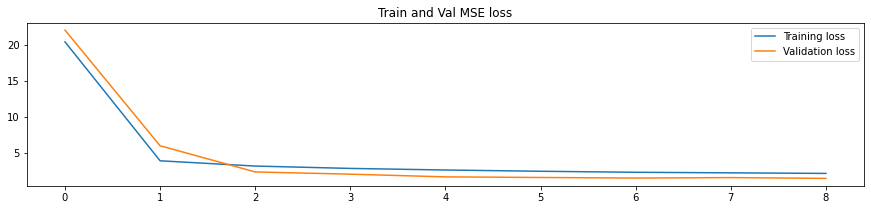

In [18]:
if __name__ == '__main__':
  main()